# Anime Face Generation - WGAN experiment
code taken from https://github.com/Zeleni9/pytorch-wgan

In [ ]:
#import necessary libraries
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pandas as pd
import os
import cv2
from PIL import Image
%matplotlib inline
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))
# define your own dataset address:
images = './dataset/images/'   #  36740 images
images2 = './dataset/images2/' #  63565 images
out2 ='./dataset/out2/'        #  25663 images
rem1 = './dataset/rem1/'       #  725 images
rem2 = './dataset/rem2/'       #  1000 images
testB = './dataset/testB/'     #  100 images
trainB = './dataset/trainB/'   #  3400 images

In [ ]:
#Seeds:
seed = 1025
torch.manual_seed(seed)
gen = torch.Generator()
gen.manual_seed(seed) # to keep shuffle persistent
random.seed(seed)
np.random.seed(seed)

## Pre-process and Load the Data
Based on the previous knowledge, students are required to complete the code for preprocessing and data loading. 
### For preprocessing 
we recommend students to use `transforms` in `torchvision`. Students are required to fill in at least two items: `Resize` and `CenterCrop`. Students can also try other **data augumentation methods** and display the results in the final report as a **bonus item**.
### Load the Data
In this part, you need define your own `Dataset` to load training images. For GAN, you don't need to load label data. Thus, defining the Dataset is easier than previous assignments.

In [ ]:
import importlib
import xfunction.transforms
from PIL import Image
importlib.reload(xfunction.transforms)

# Create your own Preprocessing methods
batch_size = 128 #The batch_size is defined by yourself based on the memory of GPU or CPU.
num_workers = 8
# i1 : (0.59441761, 0.59492202, 0.69361376), (0.2217842,  0.2510431,  0.2462906)
# i2 : (0.57181897, 0.58783819, 0.68684787), (0.24488547, 0.26629325, 0.25519701)
# ic : (0.58009647, 0.59043287, 0.6893261 ), (0.23642387, 0.26070738, 0.25193475)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform = transforms.Compose([
                                #
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                #
                                transforms.RandomHorizontalFlip(p=0.5),
                                #
                                transforms.RandomApply(
                                    [transforms.RandomChoice(
                                        [transforms.ColorJitter((0.8,1.0),  # brightness
                                                           (0.8,1.2),#(0.8,1.5), # contrast
                                                           (0.6,1.4),#(0.6,1.8), # saturation
                                                           (-0.1,0.1)), # hue
                                        #transforms.RandomEqualize(1.0),
                                        xfunction.transforms.EnhanceBrightness(1.0, 1.1, 0.2), # intensity , max_brightness, probab
                                        ], p=[0.65, 0.3]) #p=[0.8, 0.19, 0.01]) # probabilities of each transform from list above
                                    ], p = 0.2), # probability of any of the transforms above being applied
                                #
                                #transforms.RandomApply([
                                #    transforms.RandomChoice([transforms.CenterCrop(62),transforms.CenterCrop(60),transforms.CenterCrop(58),transforms.CenterCrop(56),
                                #                             transforms.CenterCrop(54)]
                                #                             , p = [0.2,0.2,0.2,0.2,0.2]),
                                #    transforms.Resize(64)], p = 0.2),
                                #
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# Complete the loading data including Dataset and Dataloader.
class AnimeData(Dataset):
    """
    Wrap the data into a Dataset class, and then pass it to the DataLoader
    :__init__: Initialization data
    :__getitem__: support the indexing such that dataset[i] can be used to get ith sample
    :__len__: return the size of the dataset.
    """
    def __init__(self, roots, transform=None):
        self.mean = None
        self.std = None
        # Load the image paths:
        self.images = []
        for root in roots:
            for img_name in os.listdir(root):
                if os.path.isfile(root+img_name) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(root+img_name)
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    
    def __getitem__(self, index):
        img = Image.open(self.images[index])
        return self.transform(img.convert("RGB"))

    def calculate_mean_std(self):
        if self.mean is None or self.std is None:
            self.mean = 0.0
            self.std = 0.0
            for img in self.images:
                img = cv2.imread(img)
                self.mean += np.mean(img,axis=(0,1))
                self.std +=np.std(img,axis=(0,1))
            self.mean /= len(self.images) * 255
            self.std /= len(self.images) * 255
        return self.mean, self.std


# Complete the trainloader
trainset = AnimeData([images],transform) # , images2, rem1, rem2, testB, trainB
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=num_workers, generator=gen, pin_memory=True)

## Visualize the input image
Note that these are color images with 3 color channels (RGB) each.

In [ ]:
#Show first batch of images from trainloader:
show_images(next(iter(trainloader)))

## Check your device and move data to device
In this part, students can check whether the computer's GPU is available and move the data to the GPU (or CPU). We strongly recommend that students use GPU to speed up the program.

`torch.cuda.is_available` can help us to check whether GPU is available.

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

## Define a GAN
A GAN consists of two adversarial networks, a discriminator and a generator.
### Discriminator
Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 3x64x64 tensor images
* The output should be a single value that will indicate whether a given image is real or fake

An example of our discriminant model is as follows, and students can also define it by themselves, including adjusting the model structure and activation function. We recommend that students use `nn.Sequential` to define the model, which is more simple and intuitive.

**Students can build models based on examples, but we suggest you try different models (including model structure and activation function). This will be regared as a bonus.**

In [ ]:
def weights_init(m):
    # custom weights initialization called on generator and discriminator
    # randomly initialized from a Normal distribution with mean=0, stdev=0.02
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Create your Discriminator model

class Critic(nn.Module):
    def __init__(self,inchannels):
        super(Critic,self).__init__()
        """
        Initialize the Discriminator Module
        :param inchannels: The depth of the first convolutional layer
        """
        self.cnn1 = nn.Sequential(
            # in: inchannels(3) x 64 x 64
            nn.Conv2d(in_channels=inchannels, out_channels=64, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16
        )
        self.cnn3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8
        )
        self.cnn4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4,stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4
        )
        self.cnn5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4,stride=1, padding=0, bias=False),
            nn.Flatten(),
            # out: 1 x 1 x 1
        )

    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        return x



discriminator=Critic(3).to(device)
#discriminator.apply(weights_init)

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `3x64x64`. This should be mostly transpose convolutional layers `nn.ConvTranspose2d` with normalization applied to the outputs.

#### Exercise: Complete the Generator model
* The inputs to the generator are vectors of some length `latent_size`
* The output should be a image of shape `3x64x64`


In [ ]:
#TODO: Create your Generator model
latent_size = 128
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        """
        Initialize the Generator Module
        :param latent_size: The length of the input latent vector
        """
        self.cnnT1 = nn.Sequential(
            # in 128 x 1 x 1
            nn.ConvTranspose2d(in_channels=latent_size,out_channels=2048,kernel_size=4,stride=1,padding=0, bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            # out: 2048 x 4 x 4
        )
        self.cnnT2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2048,out_channels=512,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # out: 512 x 8 x 8
        )
        self.cnnT3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # out: 256 x 16 x 16
        )
        self.cnnT4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # out: 128 x 32 x 32
        )
        self.cnnT5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=4,stride=2,padding=1, bias=False),
            nn.Tanh(),
            # out: 3 x 64 x 64
        )
    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 3x64x64 Tensor image as output
        """
        x = self.cnnT1(x)
        x = self.cnnT2(x)
        x = self.cnnT3(x)
        x = self.cnnT4(x)
        x = self.cnnT5(x)
        return x


class GeneratorSimple(nn.Module):
    def __init__(self,latent_size):
        super(GeneratorSimple,self).__init__()
        """
        Initialize the Generator Module
        :param latent_size: The length of the input latent vector
        """
        self.cnnT1 = nn.Sequential(
            # in: latent_size (128) x 1 x 1
            nn.ConvTranspose2d(in_channels=latent_size,out_channels=512,kernel_size=4,stride=1,padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # out: 512 x 4 x 4
        )
        self.cnnT2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # out: 256 x 8 x 8
        )
        self.cnnT3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # out: 128 x 16 x 16
        )
        self.cnnT4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # out: 64 x 32 x 32
        )
        self.cnnT5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=4,stride=2,padding=1, bias=False),
            nn.Tanh(),
            # out: 3 x 64 x 64
        )
    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 3x64x64 Tensor image as output
        """
        x = self.cnnT1(x)
        x = self.cnnT2(x)
        x = self.cnnT3(x)
        x = self.cnnT4(x)
        x = self.cnnT5(x)
        return x

class GeneratorBuff(nn.Module):
    def __init__(self,latent_size):
        super(GeneratorBuff,self).__init__()
        """
        Initialize the Generator Module
        :param latent_size: The length of the input latent vector
        """
        self.cnnT1 = nn.Sequential(
            # in: latent_size (128) x 1 x 1
            nn.ConvTranspose2d(in_channels=latent_size,out_channels=4092,kernel_size=4,stride=1,padding=0, bias=False),
            nn.BatchNorm2d(4092),
            nn.ReLU(inplace=True),
            # out: 512 x 4 x 4
        )
        self.cnnT2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4092,out_channels=2048,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            # out: 256 x 8 x 8
        )
        self.cnnT3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2048,out_channels=1024,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # out: 128 x 16 x 16
        )
        self.cnnT4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024,out_channels=128,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # out: 64 x 32 x 32
        )
        self.cnnT5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=4,stride=2,padding=1, bias=False),
            nn.Tanh(),
            # out: 3 x 64 x 64
        )
    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 3x64x64 Tensor image as output
        """
        x = self.cnnT1(x)
        x = self.cnnT2(x)
        x = self.cnnT3(x)
        x = self.cnnT4(x)
        x = self.cnnT5(x)
        return x



generator=GeneratorSimple(latent_size).to(device)
#generator.apply(weights_init)
# random latent tensors
noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
# use generator model to generate fake image
fake_images = generator(noise)
print(fake_images.shape)
# visualize the fake images by function show_images
show_images(fake_images.cpu())

---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions. We also encourage students to use the loss function in other related papers as a bonus item. If you use it, please include a citation in the report**

In [ ]:
#T Complete the loss function for training GAN
#import xfunction.vgg_loss
criterion = nn.BCELoss()

positive_labels_batch=torch.ones((batch_size, 1)).to(device)
negative_labels_batch=torch.zeros((batch_size, 1)).to(device)

def calculate_loss(preds, target):
    '''
       Calculates how close discriminator outputs are to being real
       or how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: real loss
    '''
    labels = None
    match target:
        case 0:
            labels = negative_labels_batch if len(preds) == batch_size else torch.zeros((len(preds), 1)).to(device)
        case 1:
            labels = positive_labels_batch if len(preds) == batch_size else torch.ones((len(preds) , 1)).to(device)
    loss = criterion(preds,labels)
    return loss


## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [ ]:
# Create optimizers for the discriminator D and generator G
#Define your learning rate'
max_epochs = 100
lr_g=0.0002
lr_d=0.0002
smooth = 0.8 # smooth the discriminator loss parameter
opt_d = optim.RMSprop(discriminator.parameters(), lr=lr_d)#torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas = (0.5,0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas = (0.5,0.999))
sched_d = torch.optim.lr_scheduler.MultiStepLR(opt_d,milestones=[10,20,25,35,55,80],gamma=0.75)#milestones=[25,35,45,55,65,75],gamma=0.5)
sched_g = torch.optim.lr_scheduler.MultiStepLR(opt_g,milestones=[35,55,80],gamma=0.75)#milestones=[25,35,45,55,65,75],gamma=0.5)

### Save the generated images
This code can help you save images generated from Generator G

In [ ]:
##Define your save path.
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, generator, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))
        plt.show()
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

## Training GAN to generate anime faces
Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [ ]:
def calculate_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty


In [ ]:
def calculate_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty


In [ ]:
#TODO: Complete the training function
from sklearn.metrics import accuracy_score
losses_g = []
losses_d = []
real_scores = []
fake_scores = []
REAL_LABEL = 1
FAKE_LABEL = 0

def train(discriminator, generator, d_optimizer, g_optimizer, d_scheduler, g_scheduler, epochs=1):
    iter_count = 0
    start_idx=1
    discriminator.train()
    generator.train()
    for epoch in range(epochs):
        for real_images in tqdm(trainloader):
            with torch.set_grad_enabled(True):
                real_images=real_images.to(device)
                real_batch_size = real_images.shape[0]

                # 1. Train the discriminator on real and fake images
                d_optimizer.zero_grad()

                # Pass real images through discriminator
                d_real_out = discriminator(real_images)
                real_loss = -torch.mean(d_real_out)
                real_score = torch.mean(d_real_out).item()

                real_loss.backward()

                # Generate fake images
                noise = torch.randn(real_batch_size, latent_size, 1, 1).to(device)
                fake_images = generator(noise)

                # Pass fake images through discriminator
                d_fake_out = discriminator(fake_images)
                fake_loss = torch.mean(d_fake_out)
                fake_score = torch.mean(d_fake_out).item()

                fake_loss.backward()

                # Calculate W-div gradient penalty
                #gradient_penalty = calculate_gradient_penalty(discriminator, real_images, fake_images, device)

                # Update discriminator weights
                #loss_d =  fake_loss - real_loss + gradient_penalty * 10
                #loss_d.backward()
                d_optimizer.step()

                # Weight Clipping
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)


                ## 2. Train the generator with an adversarial loss
                g_optimizer.zero_grad()

                # Generate fake images
                noise = torch.randn(real_batch_size, latent_size, 1, 1).to(device)
                fake_images = generator(noise)

                # Try to fool the discriminator
                d_fake_out = discriminator(fake_images)
                # The label is set to 1(real-like) to fool the discriminator
                loss_g = -torch.mean(d_fake_out)

                # Update generator weights
                loss_g.backward()
                g_optimizer.step()

        #d_scheduler.step()
        #g_scheduler.step()
        #losses_g.append(loss_g.item())
        #losses_d.append(loss_d.item())
        #real_scores.append(real_score)
        #fake_scores.append(fake_score)
        ## Log losses & scores (last batch)
        #print("Epoch [{}/{}], loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        #epoch+1, epochs,  loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent,generator, show=True)
            
        #state_dis = {'dis_model': discriminator.state_dict(), 'epoch': epoch}
        #state_gen = {'gen_model': generator.state_dict(), 'epoch': epoch}
        #if not os.path.isdir('checkpoint'):
        #    os.mkdir('checkpoint')
        #torch.save(state_dis, 'checkpoint/'+'D__'+str(epoch+1)) #each epoch
        #torch.save(state_gen, 'checkpoint/'+'G__'+str(epoch+1)) #each epoch
#Train the GAN
start_time=time.perf_counter()
train(discriminator, generator, opt_d, opt_g, sched_d, sched_g, epochs=max_epochs)
print(f"Training Took {time.perf_counter()-start_time} s")

In [ ]:
##Visualize your loss curve of D and G
fig, ax = plt.subplots()
plt.plot(losses_d, label='Discriminator', alpha=0.5)
plt.plot(losses_g, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
##Visualize your loss curve of D and G
fig, ax = plt.subplots()
plt.plot(losses_d[5:], label='Discriminator', alpha=0.5)
plt.plot(losses_g[5:], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
# Discriminator's scores
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'Generator.pth')
torch.save(discriminator.state_dict(), 'Discriminator.pth')

In [24]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


In [ ]:
load = False
#Load the last model
if load:
    #generator.load_state_dict(torch.load('checkpoint/G__80')['gen_model'])
    #discriminator.load_state_dict(torch.load('checkpoint/D__80')['dis_model'])
    generator.load_state_dict(torch.load('Generator.pth'))
    discriminator.load_state_dict(torch.load('Discriminator.pth'))

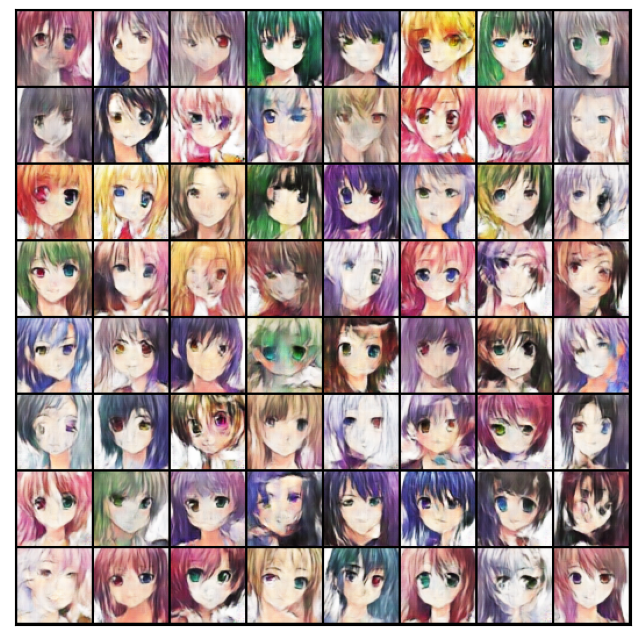

In [25]:
noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = generator(noise)
show_images(fake_images.cpu())